In [1]:
import requests
import pandas as pd
import geopandas as gpd
import os
import zipfile
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import s3fs

from scipy.signal import savgol_filter

import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from IPython.display import Image, display

from shapely import wkt

In [2]:
import s3fs

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "anhlinh"
fs.ls(MY_BUCKET)

['anhlinh/diffusion']

In [3]:
MY_BUCKET = "anhlinh"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    df_indicateurs_dep = pd.read_csv(file_in)

# Vérification
df_indicateurs_dep.head()

,Unnamed: 0,Date,Département,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois
0,0,1996-01-01,01,Homicides,0.0,499310,0.000000,1996,1
1,1,1996-01-01,02,Homicides,1.0,538017,0.018587,1996,1
2,2,1996-01-01,03,Homicides,0.0,349376,0.000000,1996,1
3,3,1996-01-01,04,Homicides,0.0,137453,0.000000,1996,1
4,4,1996-01-01,05,Homicides,0.0,118526,0.000000,1996,1


In [17]:
MY_BUCKET = "anhlinh"
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"

# Import
with fs.open(FILE_PATH_S3, "r") as file_in:
    df_indicateurs_nat = pd.read_csv(file_in)

# Vérification
df_indicateurs_nat.head()

,Unnamed: 0,Date,Zone,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois,Taux relatif,Saison
0,0,1996-01-01,France_Métro,Coups et blessures volontaires,5616.0,57936,0.969345,1996,1,1.000000,Hiver
1,1,1996-02-01,France_Métro,Coups et blessures volontaires,6115.0,57943,1.055347,1996,2,1.088722,Hiver
2,2,1996-03-01,France_Métro,Coups et blessures volontaires,6668.0,57951,1.150627,1996,3,1.187015,Printemps
3,3,1996-04-01,France_Métro,Coups et blessures volontaires,6800.0,57963,1.173162,1996,4,1.210262,Printemps
4,4,1996-05-01,France_Métro,Coups et blessures volontaires,7415.0,57976,1.278978,1996,5,1.319424,Printemps


In [18]:
df_indicateurs_dep.dtypes


Unnamed: 0          int64
Date               object
Département        object
Indicateur         object
Nombre            float64
Population          int64
Géométrie          object
Taux (/10 000)    float64
Année               int64
Mois                int64
dtype: object

In [19]:
from visualisation import tracer_evolution_taux
from visualisation import charte_graphique
from visualisation import boxplot_indicateur_par_saison
from visualisation import tracer_evolution_taux_relatif_lisse

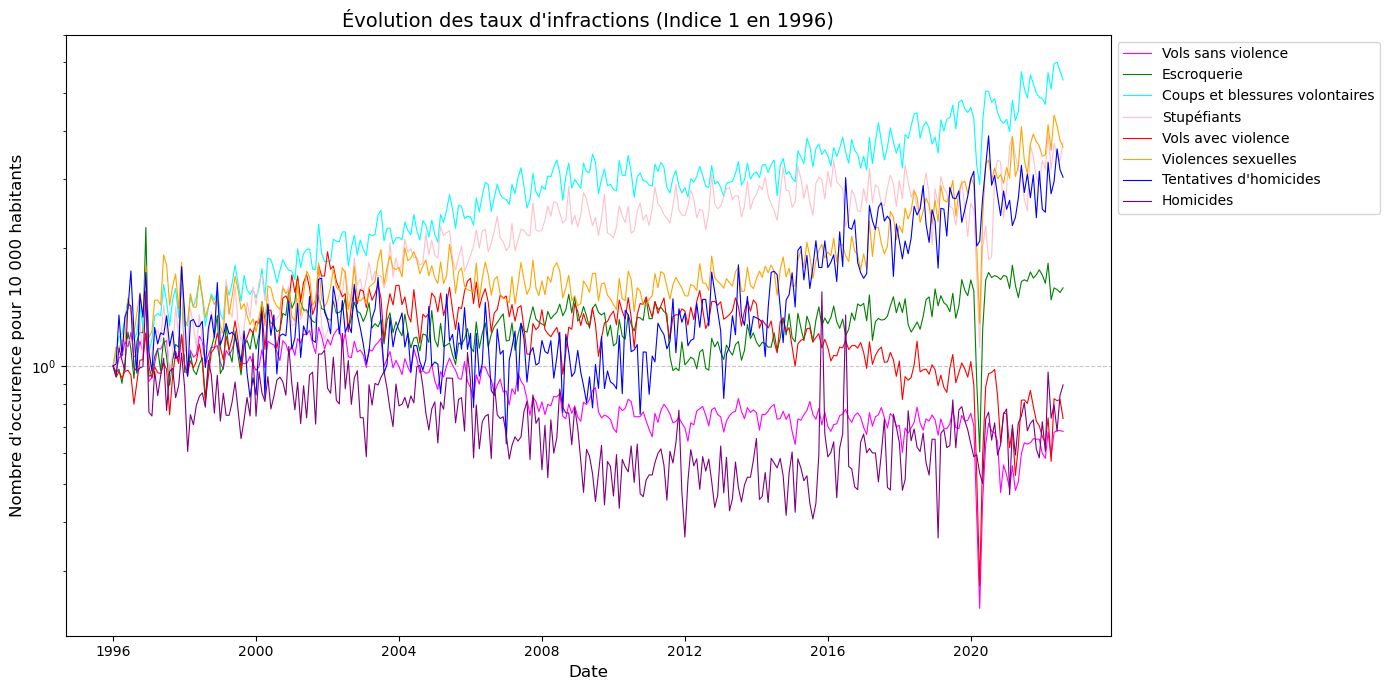

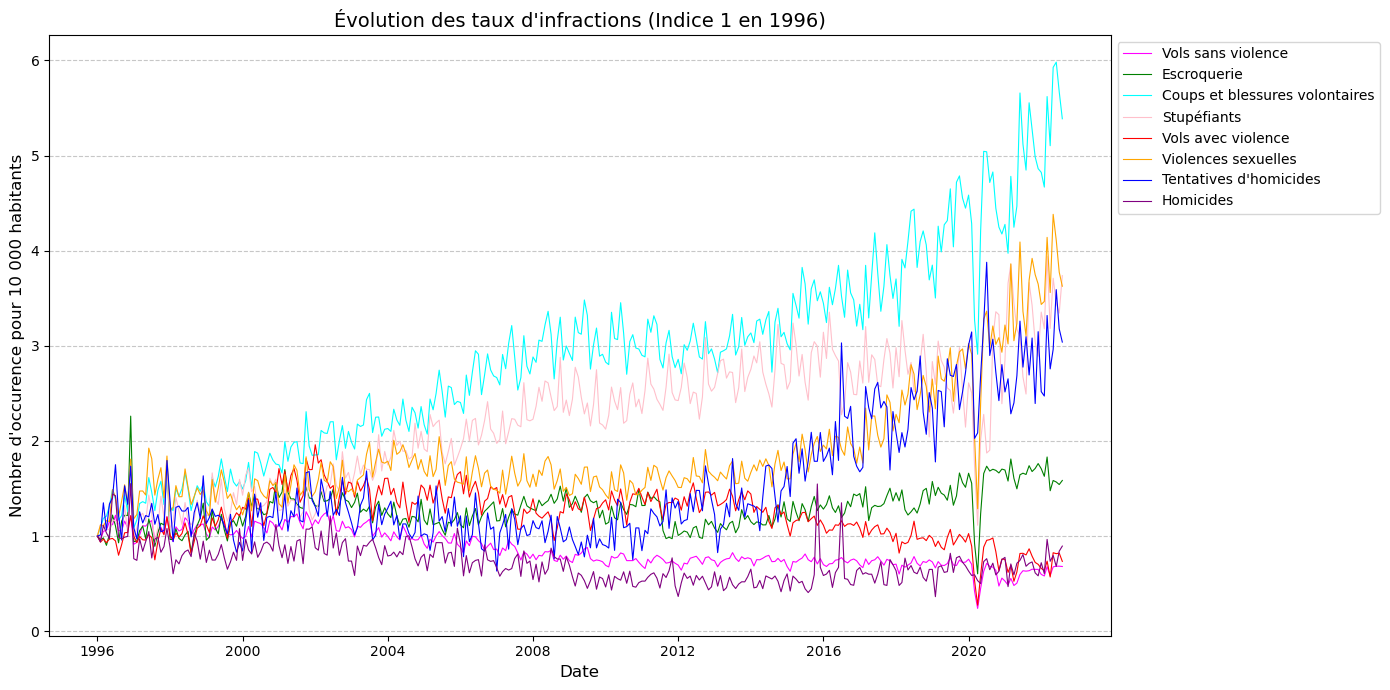

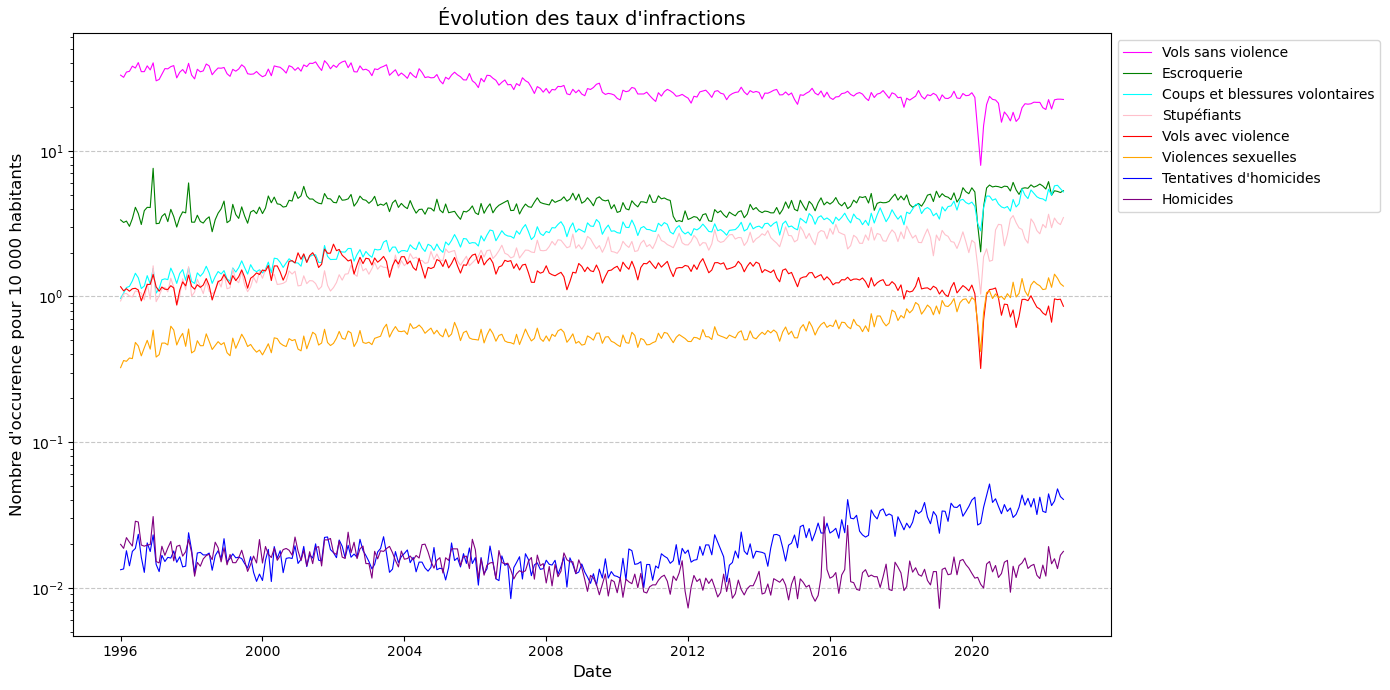

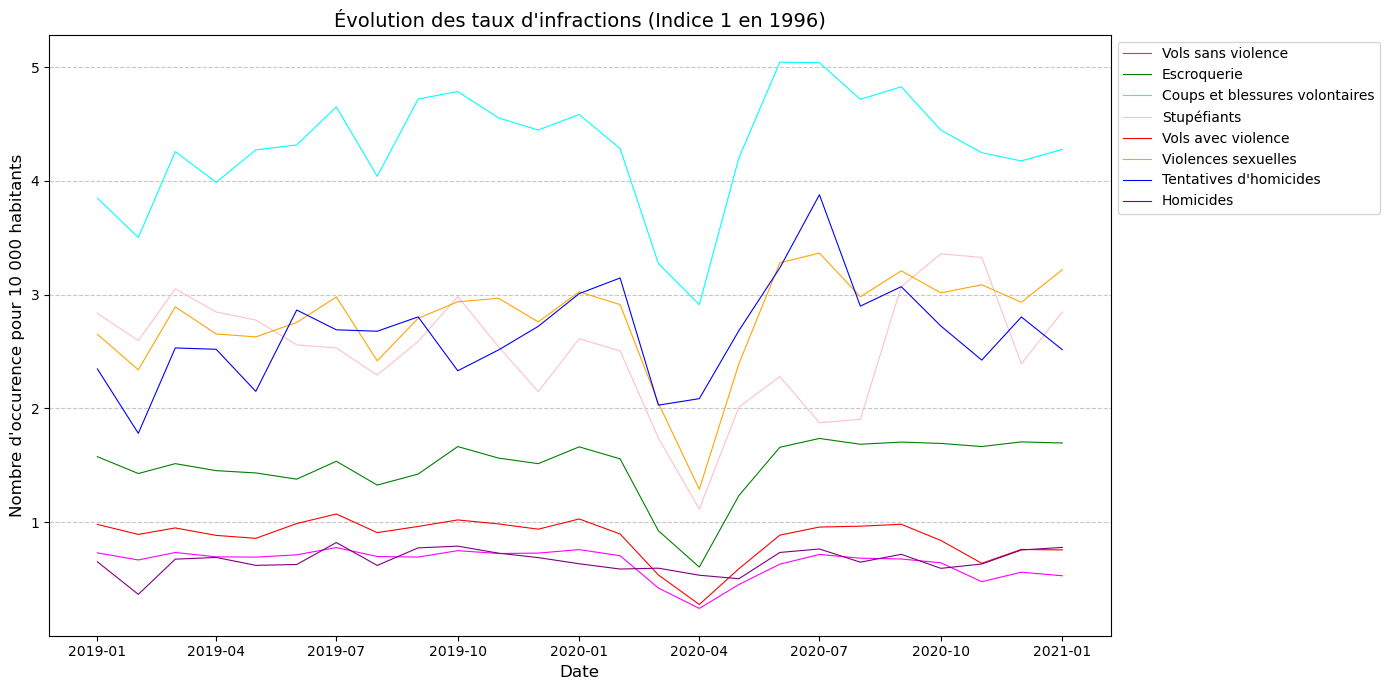

In [20]:
# Exemples d'utilisation
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Évolution des taux d'infractions (Indice 1 en 1996)", use_log_scale = True, time_period=[])
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Évolution des taux d'infractions (Indice 1 en 1996)")
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux (/10 000)", use_log_scale = True)
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Évolution des taux d'infractions (Indice 1 en 1996)", use_log_scale = False, smooth = False, time_period=["2019-01-01", "2021-01-01"])

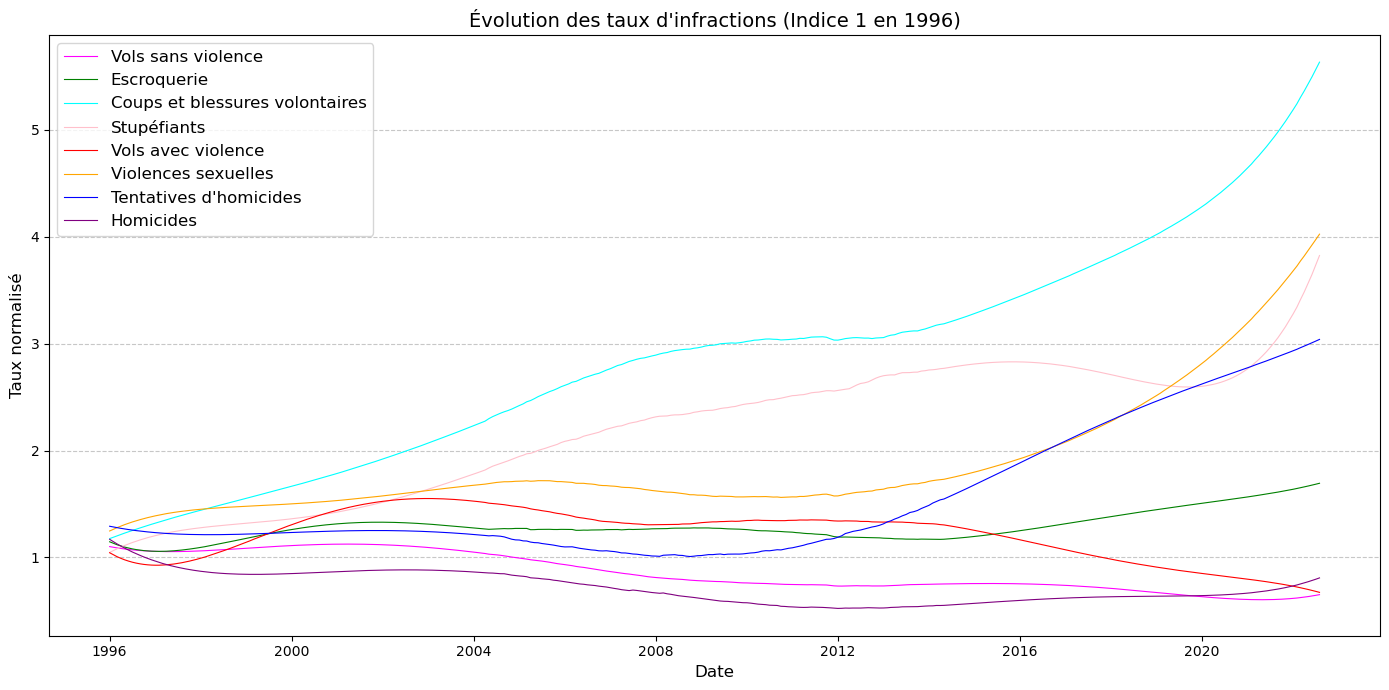

In [21]:
tracer_evolution_taux_relatif_lisse(df_indicateurs_nat, charte_graphique)

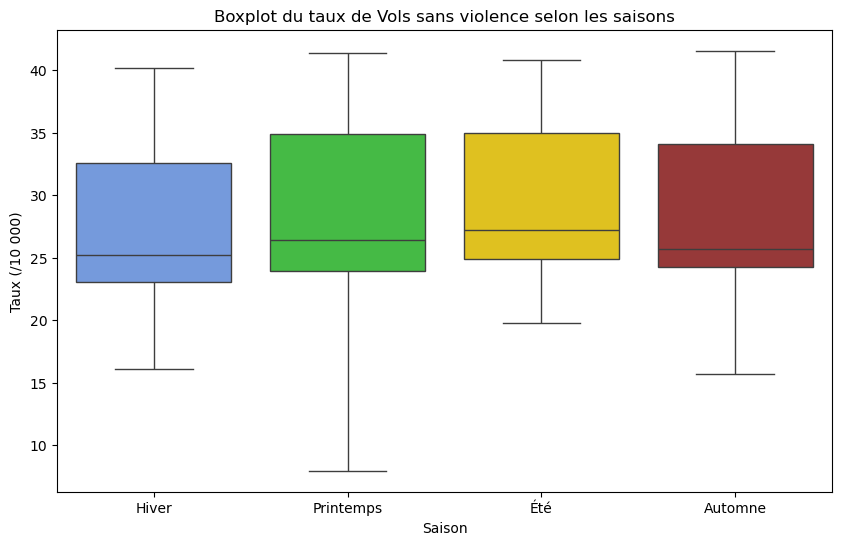

In [22]:
boxplot_indicateur_par_saison(df_indicateurs_nat, "Vols sans violence")

In [4]:
from visualisation import évolution_indicateur
from visualisation import charte_graphique2
from visualisation import dictionnaire_geo

In [5]:
print(dictionnaire_geo)

{'01': <POLYGON ((4.78 46.177, 4.78 46.189, 4.783 46.192, 4.787 46.196, 4.793 46.20...>, '02': <POLYGON ((3.173 50.011, 3.174 50.012, 3.179 50.013, 3.18 50.012, 3.183 50.0...>, '03': <POLYGON ((3.032 46.795, 3.034 46.791, 3.036 46.789, 3.037 46.784, 3.037 46....>, '04': <POLYGON ((5.676 44.191, 5.678 44.191, 5.682 44.19, 5.684 44.19, 5.686 44.18...>, '05': <POLYGON ((6.261 45.127, 6.264 45.126, 6.267 45.125, 6.268 45.122, 6.269 45....>, '06': <MULTIPOLYGON (((7.067 43.514, 7.067 43.515, 7.061 43.516, 7.06 43.515, 7.05...>, '2A': <MULTIPOLYGON (((8.586 41.874, 8.587 41.876, 8.591 41.878, 8.592 41.878, 8.5...>, '2B': <MULTIPOLYGON (((9.409 43.022, 9.407 43.023, 9.406 43.024, 9.404 43.026, 9.4...>, '07': <POLYGON ((4.483 45.236, 4.488 45.232, 4.491 45.232, 4.499 45.234, 4.504 45....>, '08': <POLYGON ((4.233 49.958, 4.237 49.959, 4.24 49.959, 4.241 49.961, 4.245 49.9...>, '09': <POLYGON ((1.688 43.274, 1.691 43.272, 1.692 43.27, 1.695 43.268, 1.697 43.2...>, '10': <POLYGON ((3.415 48.39, 3

In [5]:
from visualisation import évolution_indicateur

/home/onyxia/work/Python-pour-la-data-science-2A/data/visualisation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)
/home/onyxia/work/Python-pour-la-data-science-2A/data/visualisation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)
/home/onyxia/work/Python-pour-la-data-science-2A/data/visualisation.py:259: SettingWithCopyWarning: 
A value is trying to be s

/home/onyxia/work/Python-pour-la-data-science-2A/data/visualisation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)
/home/onyxia/work/Python-pour-la-data-science-2A/data/visualisation.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)
/home/onyxia/work/Python-pour-la-data-science-2A/data/visualisation.py:259: SettingWithCopyWarning: 
A value is trying to be s

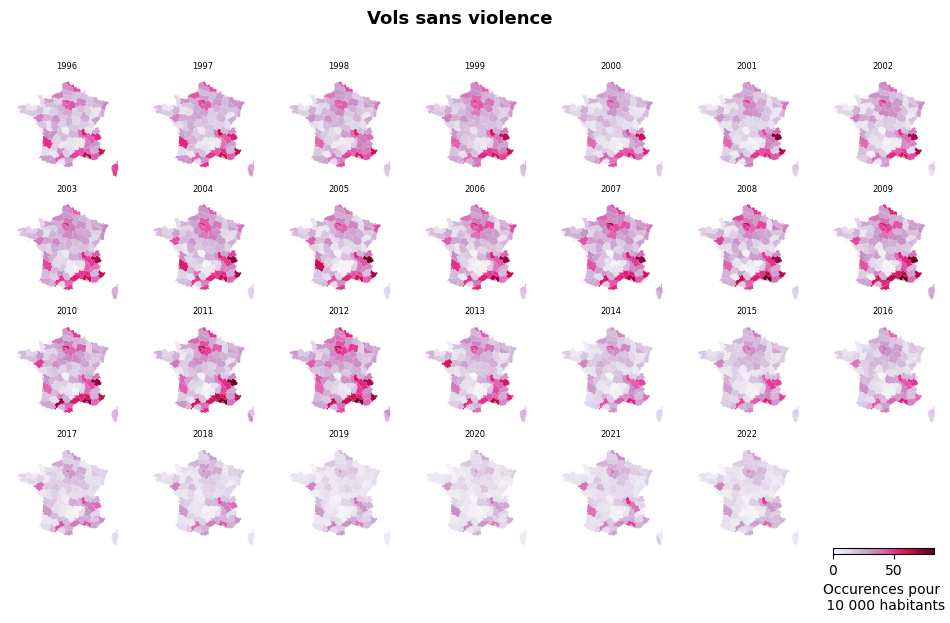

In [6]:
évolution_indicateur(df_indicateurs_dep, "Vols sans violence")

In [7]:
from visualisation import evolution_indicateur_animation

In [9]:
print(df_indicateurs_dep['Année'].dtype)  # Vérifier le type de données de la colonne Année
print(df_indicateurs_dep['Indicateur'].dtype)  # Vérifier le type de données de la colonne Indicateur


int64
object


        # Vérification des lignes sans géométrie
        if df_filtre['geometry'].isna().any():
            print(f"Année {annee} : Certaines géométries sont manquantes pour {indicateur}")
            print(df_filtre)

In [ ]:
evolution_indicateur_animation(df_indicateurs_dep, "Vols sans violence", dictionnaire_geo)

In [8]:
print("Clés du dictionnaire :", list(dictionnaire_geo.keys()))
print("Départements uniques dans le DataFrame :", df_indicateurs_dep['Département'].unique())


Clés du dictionnaire : ['01', '02', '03', '04', '05', '06', '2A', '2B', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95']
Départements uniques dans le DataFrame : ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '2A' '2B' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41'
 '42' '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55'
 '56' '57' '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69'
 '70

In [15]:
df_indicateurs_dep['Département'].dtype


dtype('O')

In [17]:
types_cles = {type(key) for key in dictionnaire_geo.keys()}
types_valeurs = {type(value) for value in dictionnaire_geo.values()}

print(f"Types des clés : {types_cles}")
print(f"Types des valeurs : {types_valeurs}")

Types des clés : {<class 'str'>}
Types des valeurs : {<class 'shapely.geometry.multipolygon.MultiPolygon'>, <class 'shapely.geometry.polygon.Polygon'>}


In [ ]:
evolution_indicateur_animation(df_indicateurs_dep, "Coups et blessures volontaires", dictionnaire_geo)

In [ ]:
evolution_indicateur_animation(df_indicateurs_dep, "Homicides", dictionnaire_geo)

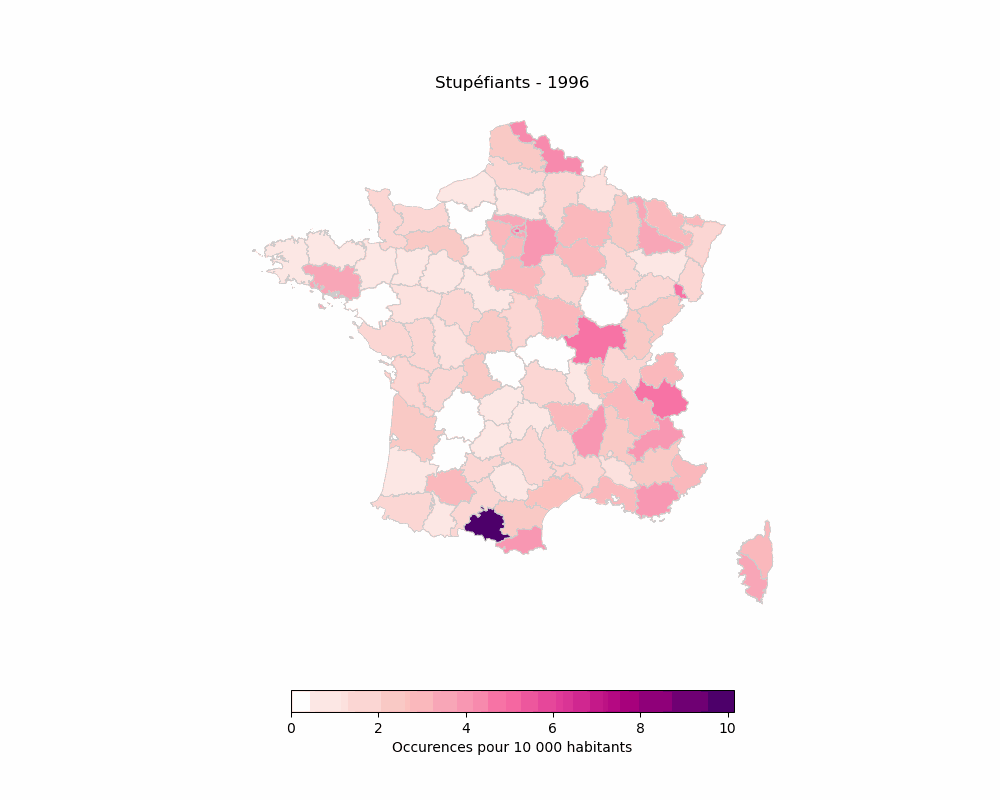

Animation sauvegardée dans animations/evolution_Stupéfiants.gif


In [10]:
evolution_indicateur_animation(df_indicateurs_dep, "Stupéfiants", dictionnaire_geo)